In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class U_net(nn.Module):
    def __init__(self, layers, params):
        super(U_net, self).__init__()
        self.params = params  
        
        # Define your network layers here
        net_layers = []

        for i in range(1, len(layers)):
            net_layers.append(nn.Linear(layers[i-1], layers[i]))
            if i < len(layers) - 1:
                net_layers.append(nn.ReLU())

        self.U = nn.Sequential(*net_layers)

    def F(self,x_f, t_f):
        # Define your additional operations here
        U_t = torch.autograd.grad(self.U_inner, t_f,torch.ones_like(t_f),create_graph=True)[0]  #ones_like(t_f)使得能计算每一对U_inner和t_f的导数
        
        U_x = torch.autograd.grad(self.U_inner, x_f, torch.ones_like(x_f),create_graph=True)[0]
        
        U_xx = torch.autograd.grad(U_x, x_f, torch.ones_like(x_f),create_graph=True)[0]
       
        return U_t + self.U_inner * U_x - self.params * U_xx
    

    def forward(self, x_u, t_u, x_f, t_f):
       
        self.U_bound = self.U(torch.cat((x_u, t_u), 1))
        self.U_inner = self.U(torch.cat((x_f, t_f), 1))
        F_output = self.F(x_f, t_f)  # Calculate the result of your additional operations

        return F_output, self.U_bound  # Return both F_output and U_output
    



In [19]:
#load data
import scipy.io
import numpy as np
from pyDOE import lhs
data = scipy.io.loadmat(r'burgers_shock.mat')

N_u = 100
N_f = 10000
params = 0.01/np.pi

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  #（x,t）的所有组合
u_star = Exact.flatten()[:,None]              

# Doman bounds
lb = X_star.min(0)  #（x,t）的最小值
ub = X_star.max(0)  #（x,t）的最大值
    
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T)) #X最小值的边界
uu1 = Exact[0:1,:].T
xx2 = np.hstack((X[:,0:1], T[:,0:1]))  #T最小值的边界
uu2 = Exact[:,0:1]
xx3 = np.hstack((X[:,-1:], T[:,-1:]))  #T最大值的边界
uu3 = Exact[:,-1:]

X_u_train = np.vstack([xx1, xx2, xx3])  #边界点纵向堆叠
X_f_train = lb + (ub-lb)*lhs(2, N_f)  #lhs生成N_f行，2列的随机数,取得Nf个内部点
#X_f_train  =lb + (ub-lb)*np.random.rand(2,N_f)
X_f_train = np.vstack((X_f_train, X_u_train))
u_train = np.vstack([uu1, uu2, uu3])

idx = np.random.choice(X_u_train.shape[0], N_u, replace=False) #从X_u_train中随机选取N_u个点
X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]


In [44]:
# Create an instance of your U_net model
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]
model = U_net(layers, params).to('cuda')

# Input data
x_bound = torch.Tensor(X_u_train[:,0:1]).to('cuda')

t_bound = torch.Tensor(X_u_train[:,1:2]).to('cuda')

x_inner = torch.Tensor(X_f_train[:,0:1]).to('cuda')
x_inner.requires_grad=True

t_inner = torch.Tensor(X_f_train[:,1:2]).to('cuda')
t_inner.requires_grad=True
u_train_tf = torch.Tensor(u_train).to('cuda')
# Forward pass through the model

# Now you can use F_output and U_output in your loss function

# Define an optimizer
optimizer = optim.LBFGS(model.parameters(),max_iter=50000,)

def loss_func(F, U):
    return torch.mean(torch.square(F)) + torch.mean(torch.square(U - u_train_tf))

# def closure():
#     optimizer.zero_grad()
#     F_output, U_output = model(x_bound, t_bound, x_inner, t_inner)
#     loss = loss_func(F_output, U_output)
#     loss.backward()
#     return loss

#Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    # Calculate the loss
    def closure():
        optimizer.zero_grad()
        F_output, U_output = model(x_bound, t_bound, x_inner, t_inner)
        loss = loss_func(F_output, U_output)
        loss.backward()
        return loss

    optimizer.step(closure)
    if (epoch + 1) % 1 == 0:
        loss = closure()
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


# optimizer = optim.SGD(model.parameters(), lr=0.01)
# num_epochs = 1000000

# for epoch in range(num_epochs):
#     # Forward pass
#     # Calculate the loss
#     F_output, U_output = model(x_bound, t_bound, x_inner, t_inner)
#     loss = loss_func(F_output, U_output)
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
#     if (epoch + 1) % 1e3 == 0:
#         print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')



Epoch [1/1000], Loss: nan


In [38]:
#predict
from scipy.interpolate import griddata
pred_x = torch.tensor(X_star[:,0:1],dtype=torch.float32).to('cuda')
pred_x.requires_grad=True
pred_t = torch.tensor(X_star[:,1:2],dtype=torch.float32).to('cuda')
pred_t.requires_grad=True

F_pred, U_pred = model(pred_x, pred_t, pred_x, pred_t) #计算相同点的F和U
#convert to numpy
U_pred = U_pred.cpu().detach().numpy()
U_interp = griddata(X_star, U_pred.flatten(), (X, T), method='cubic')  #把一列重新整理为矩阵


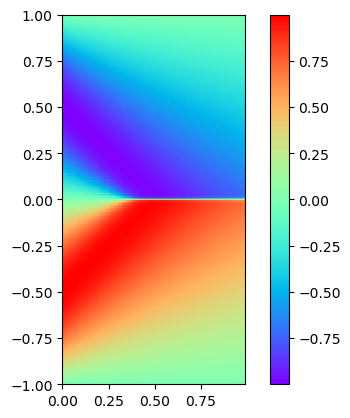

: 

In [ ]:
plt.imshow(Exact.T, interpolation='nearest', cmap='rainbow',extent=[t.min(), t.max(), x.min(), x.max()], origin='lower')
plt.colorbar()

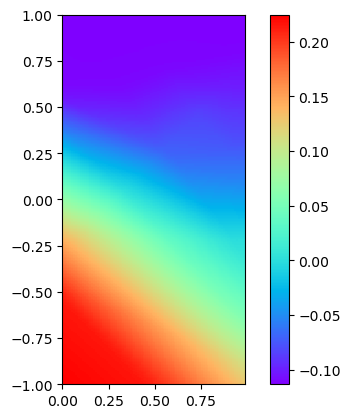

In [39]:

import matplotlib.pyplot as plt


plt.imshow(U_interp.T,interpolation='nearest', origin='lower', cmap='rainbow',extent=[lb[1], ub[1], lb[0], ub[0]])

plt.colorbar()
plt.show()
